## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from ipywidgets import IntSlider, interact
from transformers import set_seed

In [2]:
from tsfm_public import TimeSeriesPreprocessor, get_datasets
from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.time_series_imputation_pipeline import TimeSeriesImputationPipeline

## Preparing the Dataset

In [3]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 0

In [4]:
# Dataset
TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

dset_train, dset_valid, dset_test = get_datasets(
    tsp, data, split_config
)

In [5]:
print('Total TEST samples : ', len(dset_test))

Total TEST samples :  2881


## Function to mask the last forecast_length points

In [6]:
def mask_last_context(df: pd.DataFrame, forecast_length: int) -> pd.DataFrame:
    """
    Replaces the last `context_length` values in each column of the DataFrame with NaN.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        forecast_length (int): Number of values at the end of each column to mask as NaN.
    
    Returns:
        pd.DataFrame: Modified DataFrame with NaNs at the end of each column.
    """
    df_copy = df.copy()
    if forecast_length > 0:
        df_copy.iloc[-forecast_length:, :] = np.nan
    return df_copy

In [7]:
def get_forecast_with_tspulse_imputation(dset, imputation_pipeline, target_columns, FORECAST_LEN):

    lst = []
    for item in dset:
        input = item["past_values"]
        df = pd.DataFrame(input.numpy(), columns=target_columns)
        dummy_dates = pd.date_range(start='2023-01-01', periods=len(df), freq='D')
        df.insert(0, 'date', dummy_dates)   # inserting a dummy date column
    
        df = mask_last_context(df, forecast_length=FORECAST_LEN)  # introducing nan values at the end of the df
        out = imputation_pipeline(df)   # pipeline expects a pandas df as input
        out = out.select_dtypes(include='number')
        out = torch.tensor(out.values, dtype=torch.float32)
        lst.append(out)

    out_tensor = torch.stack(lst)
    return out_tensor

## Getting the Zero-Shot model

In [8]:
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    revision="tspulse-hybrid-dualhead-512-p8-r1",
    num_input_channels=tsp.num_input_channels,
    mask_type="user",
)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

## setting the pipeline

In [9]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=False,
    encode_categorical=False,
    scaler_type="standard",
)

pipe = TimeSeriesImputationPipeline(model, feature_extractor=tsp, add_known_ground_truth=False, device=device)

Device set to use cuda


## set the forecast len

In [10]:
FORECAST_LEN = 96

## call the imputation pipeline for forecasting

In [11]:
out = get_forecast_with_tspulse_imputation(dset_test, pipe, target_columns, FORECAST_LEN=FORECAST_LEN)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [12]:
out.shape

torch.Size([2881, 512, 7])

## Evaluating the Model : Calculating the MSE Loss

In [13]:
past_values_list = [item['past_values'] for item in dset_test]
ground_truth = torch.stack(past_values_list)

In [14]:
import torch.nn.functional as F

ground_truth_temp = ground_truth[:, -FORECAST_LEN:, :]
predicted_temp = out[:, -FORECAST_LEN:, :]

loss = F.mse_loss(ground_truth_temp, predicted_temp)

loss

tensor(0.3856)

## Plotting

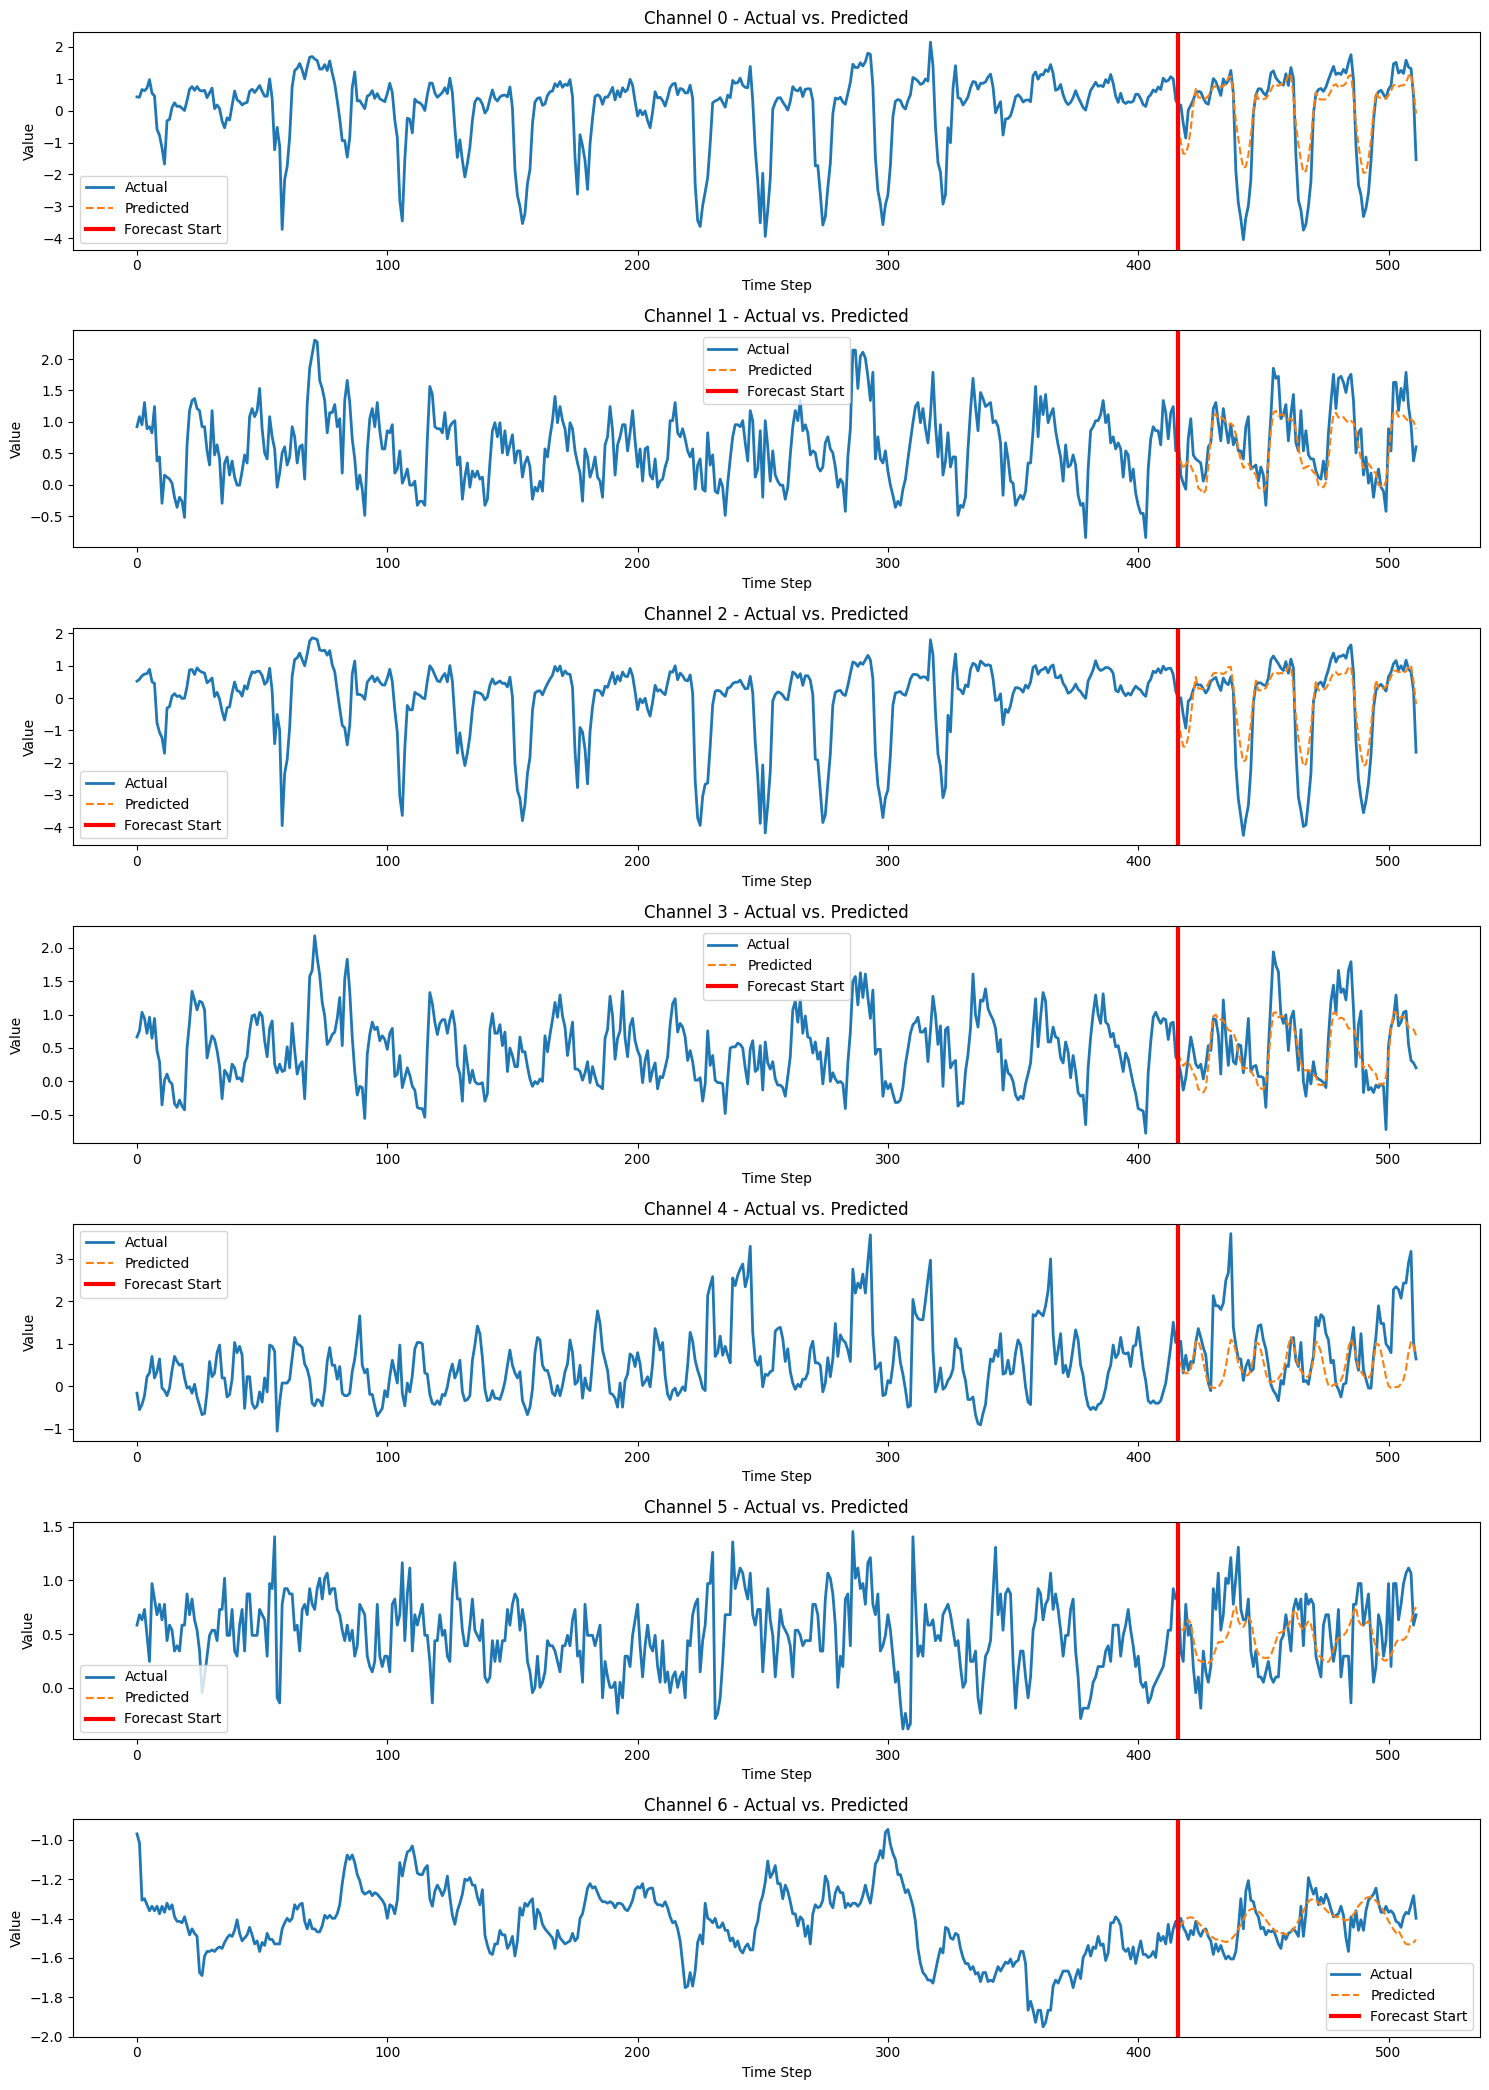

In [19]:
import torch
import matplotlib.pyplot as plt
import random

r = random.randint(0, out.shape[0])  # getting a random index to plot
channels_to_plot = list(np.arange(0, len(target_columns)))
time_steps = 96

grd = ground_truth[r, :, :]    
target = out[r, :, :]  

plt.figure(figsize=(15, 3 * len(channels_to_plot)))

for i, ch in enumerate(channels_to_plot):
    plt.subplot(len(channels_to_plot), 1, i + 1)
    plt.plot(grd[:, ch].cpu(), label='Actual', linewidth=2)
    plt.plot(range(CONTEXT_LENGTH - FORECAST_LEN, CONTEXT_LENGTH), target[-FORECAST_LEN:, ch].cpu(), label='Predicted', linestyle='--')
    plt.axvline(x=CONTEXT_LENGTH-FORECAST_LEN, color='red', linestyle='-', linewidth=3, label='Forecast Start')
    plt.title(f'Channel {ch} - Actual vs. Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()